In [25]:
#https://scotthosking.com/asl_index
#calculate ASL indices in JRA
#https://climatedataguide.ucar.edu/climate-data/amundsen-sea-low-indices

In [26]:
import cosima_cookbook as cc
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath


import scipy as sp
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame

from netCDF4 import Dataset # to work with NetCDF files
import xesmf as xe
from skimage.feature import peak_local_max


In [27]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:32783 Dashboard: /proxy/40815/status,Cluster Workers: 8 Cores: 8 Memory: 100.00 GiB


In [28]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [5]:
from cosima_cookbook import explore 
dbx = explore.DatabaseExplorer #(session=session) dbx
ee = explore.ExperimentExplorer(session=session, experiment='01deg_jra55v140_iaf')
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [29]:
expt='MRI-JRA55-do-1-4-0'

In [50]:
start = '1958-01-01 00:00:00'
end = '2018-12-31 00:00:00'

In [52]:
psl = cc.querying.getvar(expt, variable='psl', 
                       session=session, frequency='3 hourly',
                       start_time=start, 
                       end_time=end).sel(time=slice(start,end)).resample(time='M').mean(dim='time')
psl



<xarray.DataArray 'psl' (time: 732, lat: 320, lon: 640)>
dask.array<stack, shape=(732, 320, 640), dtype=float32, chunksize=(1, 320, 640), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
  * lat      (lat) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * lon      (lon) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4

In [32]:
732/12

61.0

In [58]:
#need to create land/sea mask for the psl data.
#use the era5 land sea mask -regrid it to be same size as jra55 psl
mask = xr.open_dataset('asl/data/invariant.nc').lsm
mask

#regrid from 241x480 to 320x640
reg_bil = xe.Regridder(mask, psl.isel(time=0), 'bilinear')
reg_bil  # Show information about the regridding

# Apply the regridding weights to the regrid the mask (land=1,ocean=0)
jramask = reg_bil(mask)
jramask

<xarray.DataArray 'lsm' (lat: 320, lon: 640)>
array([[1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    time     datetime64[ns] ...
  * lon      (lon) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4
  * lat      (lat) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
Attributes:
    regrid_method:  bilinear

In [59]:
#apply the land sea mask
psl_mask = psl.where(jramask == 0)
print(psl.shape,psl_mask.shape)

(732, 320, 640) (732, 320, 640)


In [35]:
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

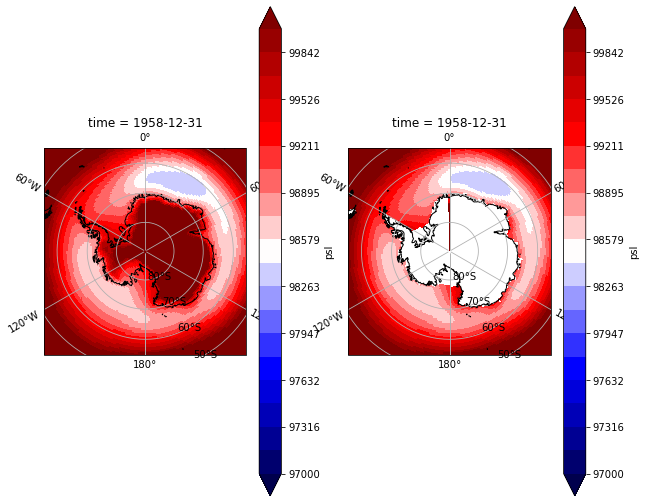

In [38]:
projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10, 9))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

ax = plt.subplot(1, 2, 1, projection=projection)

ax.set_extent([-180, 180, -80, -55], crs=ccrs.PlateCarree())
#ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

p1 = psl.isel(time=0)#slice('1979-01','1979-01')).mean('time')
p1.plot.pcolormesh(x='lon', y='lat',add_colorbar=True, levels=np.linspace(97000,100000,20),cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)

ax = plt.subplot(1, 2, 2, projection=projection)

ax.set_extent([-180, 180, -80, -55], crs=ccrs.PlateCarree())
#ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

p1 = psl_mask.isel(time=0)#slice('1979-01','1979-01')).mean('time')
p1.plot.pcolormesh(x='lon', y='lat',add_colorbar=True, levels=np.linspace(97000,100000,20),cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)



In [68]:
# from https://github.com/PaulSpence/amundsen-sea-low-index
def asl_sector_mean(da, asl_region, mask):
    a = da.where(mask == 0).sel( lat=slice(asl_region['south'],asl_region['north']), 
                lon=slice(asl_region['west'],asl_region['east']) ).mean().values
    return a


def get_lows(da, mask):
    '''
    da for one point in time (with lats x lons)
    '''
    
    lons, lats = da.lon.values, da.lat.values
    
    sector_mean_pres = asl_sector_mean(da, asl_region, mask)
    threshold = sector_mean_pres

    time_str = str(da.time.values)[:10]
    
    # fill land in with highest value to limit lows being found here
    da_max   = da.max().values
    da       = da.where(mask == 0).fillna(da_max)
        
    invert_data = (da*-1.).values     # search for peaks rather than minima
    
    if threshold is None:
        threshold_abs = invert_data.mean()
    else:
        threshold_abs  = threshold * -1  # define threshold cut-off for peaks (inverted lows)
                
    minima_yx = peak_local_max(invert_data,            # input data
                           min_distance=5,             # peaks are separated by at least min_distance
                           num_peaks=8,                # maximum number of peaks
                           exclude_border=False,       # excludes peaks from within min_distance pixels of the border
                           threshold_abs=threshold_abs # minimum intensity of peaks
                           )
    
    minima_lat, minima_lon, pressure = [], [], []
    for minima in minima_yx:
        minima_lat.append(lats[minima[0]])
        minima_lon.append(lons[minima[1]])
        pressure.append(da.values[minima[0],minima[1]])
    
    df = pd.DataFrame()
    df['lat']        = minima_lat
    df['lon']        = minima_lon
    df['ActCenPres'] = pressure
    df['SectorPres'] = sector_mean_pres
    df['time']       = time_str
    
    ### Add relative central pressure (Hosking et al. 2013)
    df['RelCenPres'] = df['ActCenPres'] - df['SectorPres']

    ### re-order columns
    df = df[['time','lon','lat','ActCenPres','SectorPres','RelCenPres']]
    
    ### clean-up DataFrame
    df = df.reset_index(drop=True)

    return df


def define_asl(df, region):
    ### select only those points within ASL box
    df2 = df[(df['lon'] > region['west'])  & 
                (df['lon'] < region['east'])  & 
                (df['lat'] > region['south']) & 
                (df['lat'] < region['north']) ]

    ### For each time, get the row with the lowest minima_number
    df2 = df2.loc[df2.groupby('time')['ActCenPres'].idxmin(skipna=False)]
    
    df2 = df2.reset_index(drop=True)

    return df2


def slice_region(da, region, boarder=8):
    da = da.sel(#lat=slice(region['north']+boarder,region['south']-boarder), Mod due to -90 to 90 vs 90 to -90
                lat=slice(region['south']-boarder,region['north']+boarder), 
                lon=slice(region['west']-boarder,region['east']+boarder))
    return da

print(psl.shape,psl_mask.shape)
# region of interest (asl sector)
asl_region = {'west':170., 'east':298., 'south':-80., 'north':-60.}

### slice area around ASL region
apsl      = slice_region(psl, asl_region)
apsl_mask = slice_region(psl_mask, asl_region)

print(apsl.shape,apsl_mask.shape)

apsl

plt.figure(figsize=(5,5))
ax1 = plt.subplot( 121, projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )
ax1.set_extent([-180,180,-90,-50], ccrs.PlateCarree())
apsl.isel(time=0).plot.pcolormesh('lon','lat', cmap='Reds', 
                                        transform=ccrs.PlateCarree(), add_colorbar=False )

ax2 = plt.subplot( 122, projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )
ax2.set_extent([-180,180,-90,-50], ccrs.PlateCarree())
apsl_mask.isel(time=0).plot.pcolormesh('lon','lat', cmap='Reds', 
                                        transform=ccrs.PlateCarree(), add_colorbar=True )
#p1 = psl_mask.sel(time=slice(start,end)).mean('time').plot.pcolormesh(x='lon', y='lat',add_colorbar=True, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())


# change units from Pa to hPa
start = '1978-12-31 00:00:00'
end='1980-01-01 00:00:00'

psl = psl.sel(time=slice(start,end)) / 100. 
psl = psl.assign_attrs(units='hPa')

ntime        = psl.time.shape[0]
all_lows_dfs = pd.DataFrame()
print(ntime)
for t in range(0,ntime):
    print(t)
    psl_t         = psl.isel(time=t)
    #print(psl_t.shape,jramask.shape)
    all_lows_df  = get_lows(psl_t, jramask)
    #print(all_lows_df.shape)
    all_lows_dfs = pd.concat([all_lows_dfs, all_lows_df], ignore_index=True)

asl_df = define_asl(all_lows_dfs, asl_region)

asl_df

In [69]:
# change units from Pa to hPa
start = '2018-01'
end='2018-12'

asl_region = {'west':170., 'east':298., 'south':-80., 'north':-60.}

psl2 = psl.sel(time=slice(start,end)) / 100. 
psl2 = psl2.assign_attrs(units='hPa')
print(psl2.shape)

ntime        = psl2.time.shape[0]
all_lows_dfs = pd.DataFrame()
print(ntime)
for t in range(0,ntime):
    print(t)
    psl_t         = psl2.isel(time=t)
    print(psl_t.time,psl_t.shape,jramask.shape)
    all_lows_df  = get_lows(psl_t, jramask)
    print(all_lows_df.shape)
    all_lows_dfs = pd.concat([all_lows_dfs, all_lows_df], ignore_index=True)
    print(all_lows_dfs.shape)
       
asl_df_mask = define_asl(all_lows_dfs, asl_region)
np.save('ensoant/jra55_asl_df_mnth_1801to1812.npy',asl_df_mask)
np.save('ensoant/jra55_all_lows_dfs_mnth_1801to1812.npy',all_lows_dfs)

(12, 320, 640)
12
0
<xarray.DataArray 'time' ()>
array('2018-01-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-01-31 (320, 640) (320, 640)
(6, 6)
(6, 6)
1
<xarray.DataArray 'time' ()>
array('2018-02-28T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-02-28 (320, 640) (320, 640)
(4, 6)
(10, 6)
2
<xarray.DataArray 'time' ()>
array('2018-03-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-03-31 (320, 640) (320, 640)
(6, 6)
(16, 6)
3
<xarray.DataArray 'time' ()>
array('2018-04-30T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-04-30 (320, 640) (320, 640)
(6, 6)
(22, 6)
4
<xarray.DataArray 'time' ()>
array('2018-05-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-05-31 (320, 640) (320, 640)
(6, 6)
(28, 6)
5
<xarray.DataArray 'time' ()>
array('2018-06-30T00:00:00.000000000'

In [83]:
#append in 2018 mnthy data
#asl_df_mask

b=np.load('ensoant/jra55_asl_df_mnth_1801to1812.npy',allow_pickle=True)
a=np.load('ensoant/jra55_asl_df_58to17.npy',allow_pickle=True)
c=np.append(a,b,axis=0)
print(a.shape,b.shape,c.shape,c[701,:])

np.save('ensoant/jra55_asl_df_mnth_5801to1812.npy',c)

df2 = pd.DataFrame(np.load('ensoant/jra55_asl_df_mnth_5801to1812.npy',allow_pickle=True), 
             columns=['time','lon','lat','ActCenPres','SectorPres','SectorPres'])

df2

(690, 6) (12, 6) (702, 6) ['2018-12-31' 273.9375 -67.6753372320917 975.80615234375 982.5479736328125
 -6.7418212890625]


,time,lon,lat,ActCenPres,SectorPres,SectorPres
0,1958-01-31,278.4375,-68.236955,983.171021,989.59137,-6.420349
1,1958-02-28,213.75,-69.921806,987.755798,991.843811,-4.088013
2,1958-03-31,239.625,-63.182389,986.214111,990.699036,-4.484924
3,1958-04-30,289.6875,-65.428865,985.633179,996.040222,-10.407043
4,1958-06-30,184.5,-64.867246,973.702087,988.303955,-14.601868
...,...,...,...,...,...,...
697,2018-08-31,271.125,-69.360189,979.019043,988.390808,-9.371765
698,2018-09-30,230.625,-71.606655,974.093933,981.382141,-7.288208
699,2018-10-31,212.625,-71.606655,967.571655,978.916443,-11.344788
700,2018-11-30,276.75,-68.798572,970.024536,978.582092,-8.557556


In [80]:
#append in 2018 mnthy data
#all_lows_dfs

b=np.load('ensoant/jra55_all_lows_dfs_mnth_1801to1812.npy',allow_pickle=True)
a=np.load('ensoant/jra55_all_lows_dfs_58to17.npy',allow_pickle=True)
c=np.append(a,b,axis=0)
print(a.shape,b.shape,c.shape,c[3265,:])

np.save('ensoant/jra55_all_lows_dfs_mnth_5801to1812.npy',c)

df2 = pd.DataFrame(np.load('ensoant/jra55_all_lows_dfs_mnth_5801to1812.npy',allow_pickle=True), 
             columns=['time','lon','lat','ActCenPres','SectorPres','SectorPres'])

df2

(3200, 6) (66, 6) (3266, 6) ['2018-12-31' 37.6875 -64.3056273245713 981.57373046875 982.5479736328125
 -0.9742431640625]


,time,lon,lat,ActCenPres,SectorPres,SectorPres
0,1958-01-31,33.1875,-61.497532,978.590027,989.59137,-11.001343
1,1958-01-31,278.4375,-68.236955,983.171021,989.59137,-6.420349
2,1958-01-31,321.1875,-62.62077,986.870239,989.59137,-2.72113
3,1958-01-31,220.5,-72.729885,987.422119,989.59137,-2.16925
4,1958-01-31,111.375,-62.62077,987.758118,989.59137,-1.833252
...,...,...,...,...,...,...
3261,2018-11-30,325.6875,-69.360189,975.156067,978.582092,-3.426025
3262,2018-12-31,320.625,-68.236955,975.228149,982.547974,-7.319824
3263,2018-12-31,273.9375,-67.675337,975.806152,982.547974,-6.741821
3264,2018-12-31,110.25,-60.374292,979.931641,982.547974,-2.616333


In [92]:
#replace missing lows with nans
asl_df_mask_all=np.load('ensoant/jra55_asl_df_mnth_5801to1812.npy',allow_pickle=True)
print(asl_df_mask_all.shape)

df2 = pd.DataFrame(np.load('ensoant/jra55_asl_df_mnth_5801to1812.npy',allow_pickle=True), 
             columns=['time','lon','lat','ActCenPres','SectorPres','SectorPres'])

#print(df2.shape)
df2['time'] = pd.to_datetime(df2['time'])
print(df2.shape)
df2 = (df2.set_index('time')
       .reindex(pd.date_range("1958-01-31", "2018-12-31", freq='M')))
print(df2.shape)

df2.reset_index(inplace=True)
df2 = df2.rename(columns = {'index':'time'})
print(df2.shape)

np.save('ensoant/jra55_asl_df_mnth_5801to1812_wnans.npy',df2)

(702, 6)
(702, 6)
(732, 5)
(732, 6)


In [93]:
df2

,time,lon,lat,ActCenPres,SectorPres,SectorPres
0,1958-01-31,278.4375,-68.236955,983.171021,989.59137,-6.420349
1,1958-02-28,213.75,-69.921806,987.755798,991.843811,-4.088013
2,1958-03-31,239.625,-63.182389,986.214111,990.699036,-4.484924
3,1958-04-30,289.6875,-65.428865,985.633179,996.040222,-10.407043
4,1958-05-31,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
727,2018-08-31,271.125,-69.360189,979.019043,988.390808,-9.371765
728,2018-09-30,230.625,-71.606655,974.093933,981.382141,-7.288208
729,2018-10-31,212.625,-71.606655,967.571655,978.916443,-11.344788
730,2018-11-30,276.75,-68.798572,970.024536,978.582092,-8.557556


In [94]:
#asl_region = {'west':170., 'east':298., 'south':-80., 'north':-60.}

#asl_df_mask_all=np.load('/g/data/v45/pas561/gdcc21/ensoant/jra55_asl_df_58to17_wnans.npy',allow_pickle=True)
#print(asl_df_mask_all.shape)

#needs to be a panda data frame for plotting below
asl_df_mask_all = pd.DataFrame(np.load('ensoant/jra55_asl_df_mnth_5801to1812_wnans.npy',allow_pickle=True), 
             columns=['time','lon','lat','ActCenPres','SectorPres','SectorPres'])
asl_df_mask_all

,time,lon,lat,ActCenPres,SectorPres,SectorPres
0,1958-01-31,278.4375,-68.236955,983.171021,989.59137,-6.420349
1,1958-02-28,213.75,-69.921806,987.755798,991.843811,-4.088013
2,1958-03-31,239.625,-63.182389,986.214111,990.699036,-4.484924
3,1958-04-30,289.6875,-65.428865,985.633179,996.040222,-10.407043
4,1958-05-31,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
727,2018-08-31,271.125,-69.360189,979.019043,988.390808,-9.371765
728,2018-09-30,230.625,-71.606655,974.093933,981.382141,-7.288208
729,2018-10-31,212.625,-71.606655,967.571655,978.916443,-11.344788
730,2018-11-30,276.75,-68.798572,970.024536,978.582092,-8.557556


In [95]:
def draw_regional_box( region, transform=None ):
    '''
    Draw box around a region on a map
    region is a dictionary with west,east,south,north
    '''

    if transform == None:
        transform = ccrs.PlateCarree()

    plt.plot([region['west'], region['west']], [region['south'],region['north']], 
                 'k-', transform=transform, linewidth=1)
    plt.plot([region['east'], region['east']], [region['south'],region['north']], 
                 'k-', transform=transform, linewidth=1)
    
    for i in range( np.int(region['west']),np.int(region['east']) ): 
        plt.plot([i,i+1], [region['south'],region['south']], 'k-', transform=transform, linewidth=1)
        plt.plot([i,i+1], [region['north'],region['north']], 'k-', transform=transform, linewidth=1)

2018-01-31
(1, 6)
2018-02-28
(1, 6)
2018-03-31
(1, 6)
2018-04-30
(1, 6)
2018-05-31
(1, 6)
2018-06-30
(1, 6)
2018-07-31
(1, 6)
2018-08-31
(1, 6)
2018-09-30
(1, 6)
2018-10-31
(1, 6)
2018-11-30
(1, 6)
2018-12-31
(1, 6)



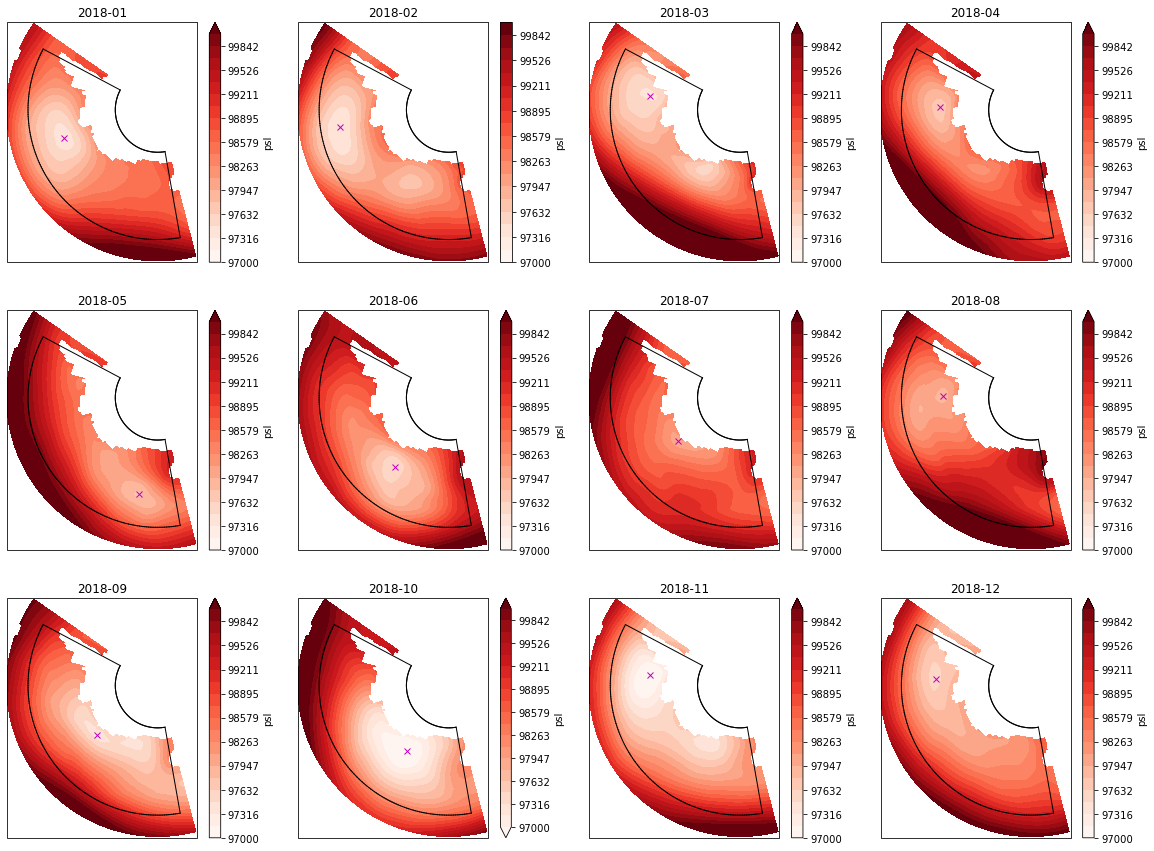

In [96]:
asl_region = {'west':170., 'east':298., 'south':-80., 'north':-60.}

start = '2018-01'
end='2018-12'

plt.figure(figsize=(20,15))

for i in range(0,12):
    
    psl_2D = psl_mask.sel(time=slice(start,end)).isel(time=i)
    psl_2D = psl_2D.sel(lat=slice(-90,-55),lon=slice(165,305))

    ax = plt.subplot( 3, 4, i+1, 
                        projection=ccrs.Stereographic(central_longitude=0., 
                                                      central_latitude=-90.) )

    ax.set_extent([165,305,-85,-55], ccrs.PlateCarree())

    result = psl_2D.plot.contourf( 'lon', 'lat', cmap='Reds', 
                                    transform=ccrs.PlateCarree(), 
                                    add_colorbar=True, 
                                    levels=np.linspace(97000,100000,20)) #(np.nanmin(psl_2D.values), np.nanmax(psl_2D.values), 20) )

    # ax.coastlines(resolution='110m')
    ax.set_title(str(psl_2D.time.values)[0:7])

    ## mark ASL
    print(str(psl_2D.time.values)[0:10])
    df2 = asl_df_mask_all[ asl_df_mask_all['time'] == str(psl_2D.time.values)[0:10]]
    print(df2.shape)
    if len(df2) > 0:
        ax.plot(df2['lon'], df2['lat'], 'mx', transform=ccrs.PlateCarree() )
    draw_regional_box(asl_region)

print('')

In [61]:
print(str(psl_2D.time.values))
psl_mask

1994-12-31T00:00:00.000000000


<xarray.DataArray 'psl' (time: 732, lat: 320, lon: 640)>
dask.array<where, shape=(732, 320, 640), dtype=float32, chunksize=(1, 320, 640), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
  * lat      (lat) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * lon      (lon) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4

In [14]:
#plot the era5_asl data from https://github.com/PaulSpence/amundsen-sea-low-index
#era5_asl=np.load('/g/data/v45/pas561/gdcc21/asl/era5_asl.npy',allow_pickle=True)
#print(era5_asl.shape)